<a href="https://colab.research.google.com/github/QuinnGrace/Sasol/blob/tuned_with_features_sampled/SasolCustomerRetention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sasol Customer Retention

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
# Dataframe and Visualisation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Downsampling
from sklearn.utils import resample

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from xgboost import XGBClassifier

# Handling Nulls
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

# Colab and Warning
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

### 1. Load The Dataset

In [3]:
# Load files into a pandas dataframe
path = "/content/drive/MyDrive/Colab Notebooks/Data/Sasol/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
ss = pd.read_csv(path+'SampleSubmission.csv')
variables = pd.read_csv(path+'VariableDescription.csv')

In [4]:
# Change the sample submission back to a csv file
ss.to_csv(path+"new_ss.csv", index=False)

In [5]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (1507834, 19)
test data shape : (380127, 18)


This is a huge dataset, so we may need to train on a subset of the data, depending on the model that is used.

We have 18 independent variables and 1 dependent variable. Let's see what those are.

In [6]:
# Inspect train data
train.head()

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,ID_QS4F5LEX29KM,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


Already we can see that there are lots of nulls that need addressing as well as features that need to be engineered. Before we do that, let's examine the target feature.

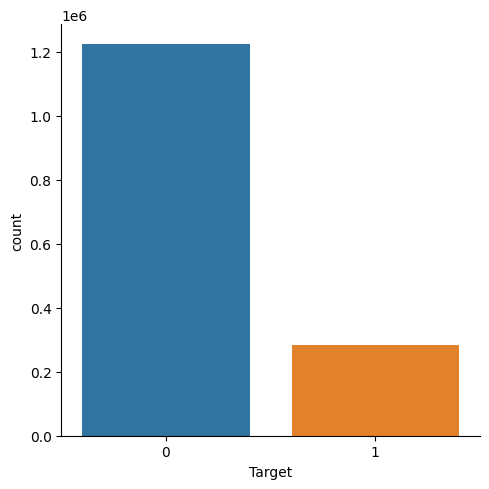

In [7]:
# Explore Target distribution
sns.catplot(x="Target", kind="count", data=train)

There is a large imbalance of data, far more clients are inactive than active. To prevent the model from becoming biased, this will need to be balanced out later on. (We do that in 3.2. Downsampling).

Let's examine the nulls.

### 2. Understand The Dataset


### 2.1. Nulls

In [8]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: ID                        0
region               594091
tenure                    0
Amount               529514
refill_frequency     529514
revenue              508121
arpu_segment         508121
frequency            508121
data_volume          741806
on_net               550642
Procuct_1            626563
Procuct_2            903050
zone1               1388848
zone2               1412329
mrg                       0
regularity                0
top_pack             631823
freq_top_pack        631823
Target                    0
dtype: int64


Majority of zone1 and zone2 do not have many values. This could be an issue, so they will need to be dropped along with other columns that are missing more than 50% of their values (753900 or more). Let's investigate the relationship between the missing values.

<Axes: >

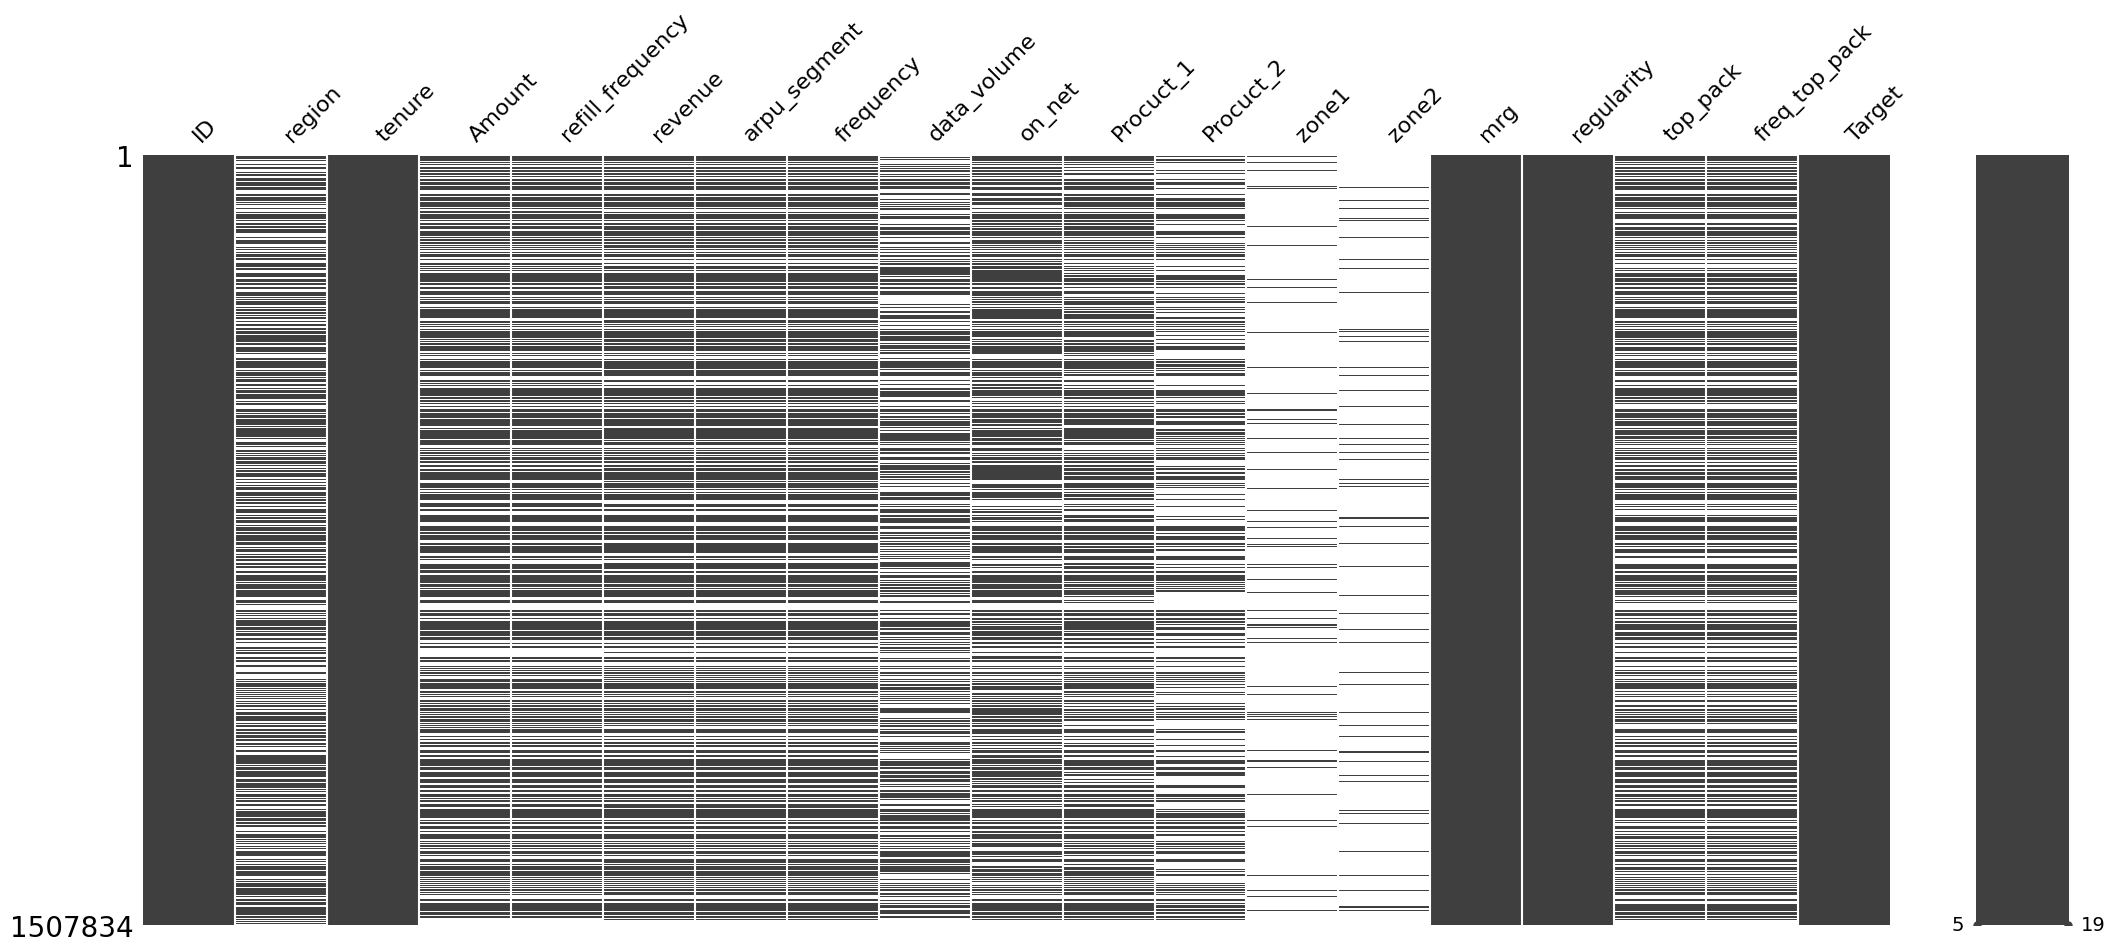

In [10]:
msno.matrix(train)

The msno.matrix nullity matrix is a data-dense display which will allow us to quickly visually pick out patterns in data completion

Clearly the values are not missing at random.


*   Region, Amount, refill_frequency, revenue, arpu_segment, frequency, on_net, top_pack, and freq_top_pack are all correlated.

Let us sort the matrix to see if we can delete the columns that are sparsely populated.



<Axes: >

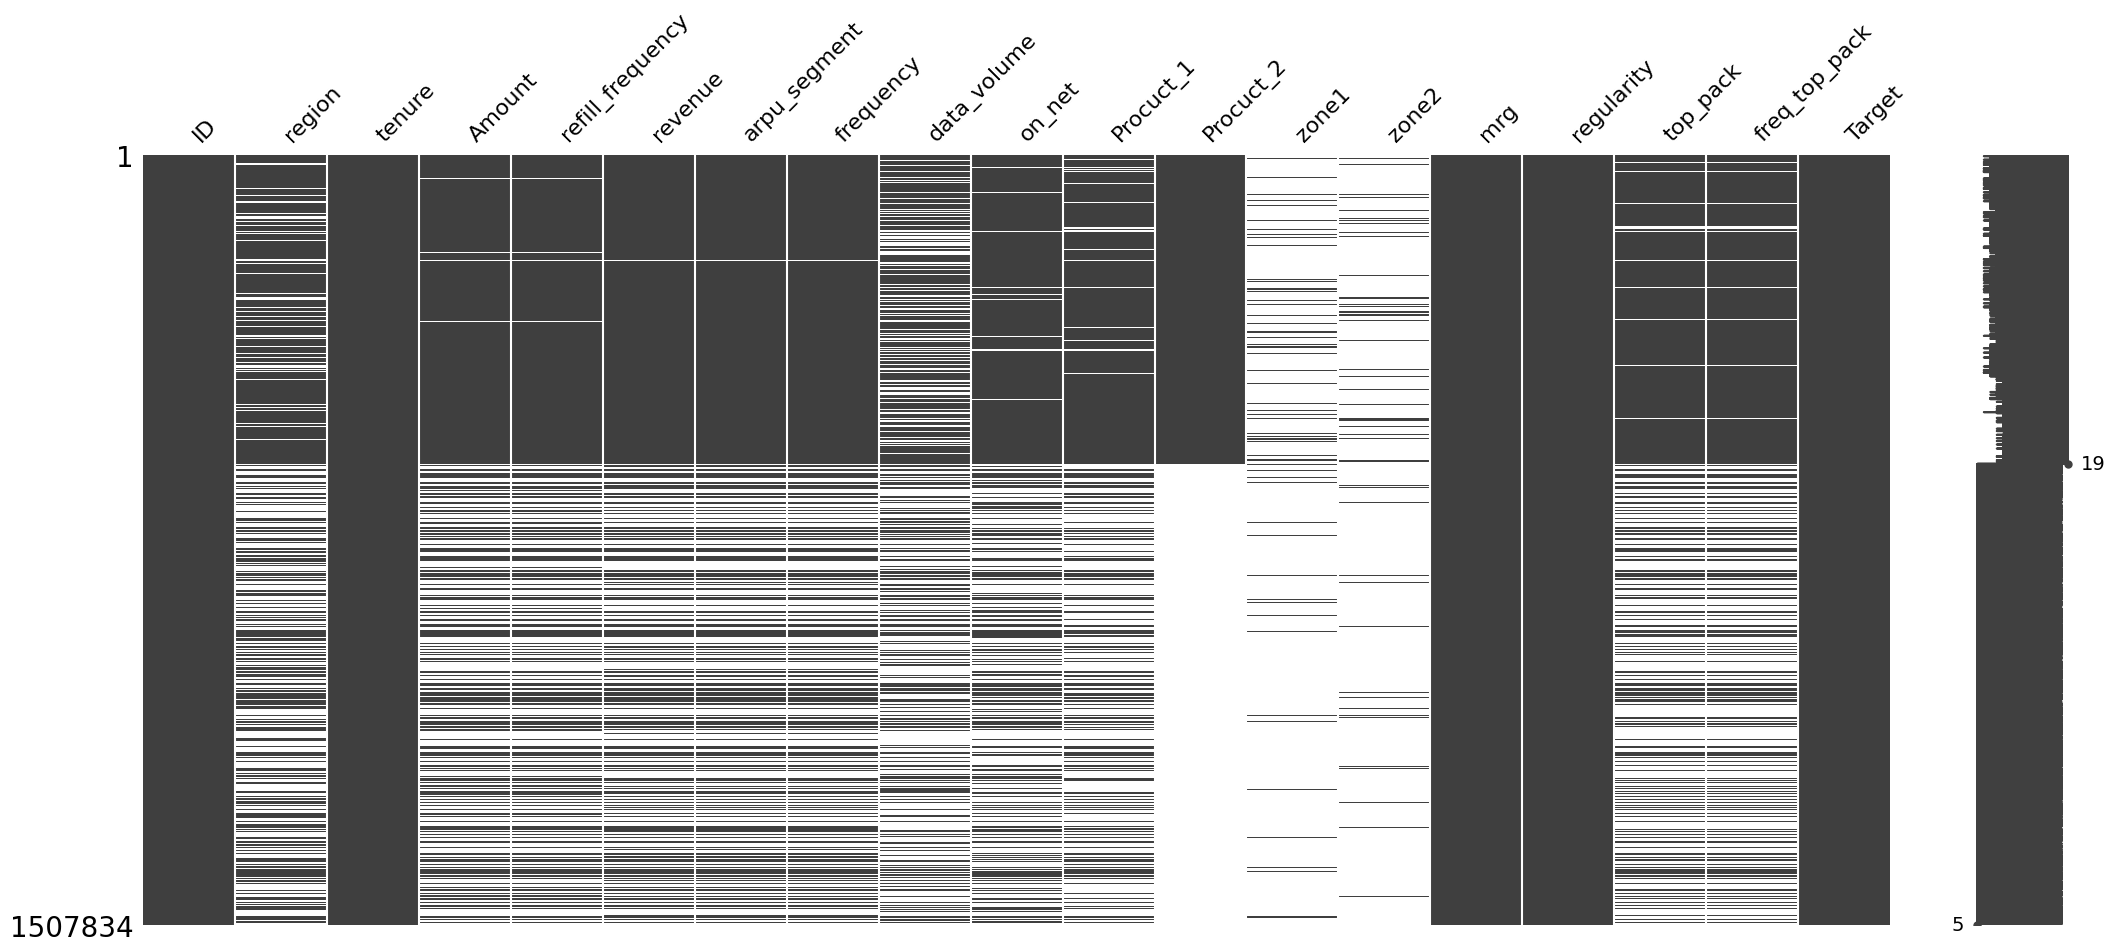

In [11]:
# Sorted by Procuct_2
sorted = train.sort_values('Procuct_2')
msno.matrix(sorted)

Procuct_2 cannot be safely deleted as it correlates with the other columns. zone1 and zone2 can be deleted though.

In [12]:
# Deleting the zone columns
train_nonull = train.drop(['zone1','zone2'], axis=1)
test_nonull = test.drop(['zone1','zone2'], axis=1)

In [14]:
# Checking the null columns are gone
train_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID                1507834 non-null  object 
 1   region            913743 non-null   object 
 2   tenure            1507834 non-null  object 
 3   Amount            978320 non-null   float64
 4   refill_frequency  978320 non-null   float64
 5   revenue           999713 non-null   float64
 6   arpu_segment      999713 non-null   float64
 7   frequency         999713 non-null   float64
 8   data_volume       766028 non-null   float64
 9   on_net            957192 non-null   float64
 10  Procuct_1         881271 non-null   float64
 11  Procuct_2         604784 non-null   float64
 12  mrg               1507834 non-null  object 
 13  regularity        1507834 non-null  int64  
 14  top_pack          876011 non-null   object 
 15  freq_top_pack     876011 non-null   float64
 16  

For the rest of the nulls, we will impute them using the MICE technique so as not to lose valuable data. This will happen once the data is clean and ready to use. (In step 3.1. Preprocessing)

### 2.2. Data Types

In [20]:
#Show the datatypes
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ID                1507834 non-null  object 
 1   region            913743 non-null   object 
 2   tenure            1507834 non-null  object 
 3   Amount            978320 non-null   float64
 4   refill_frequency  978320 non-null   float64
 5   revenue           999713 non-null   float64
 6   arpu_segment      999713 non-null   float64
 7   frequency         999713 non-null   float64
 8   data_volume       766028 non-null   float64
 9   on_net            957192 non-null   float64
 10  Procuct_1         881271 non-null   float64
 11  Procuct_2         604784 non-null   float64
 12  zone1             118986 non-null   float64
 13  zone2             95505 non-null    float64
 14  mrg               1507834 non-null  object 
 15  regularity        1507834 non-null  int64  
 16  

We can now see that there are 5 objects, 2 ints, and the rest are floats. The ones that are not floats will need to be converted.

### 2.3. Outliers

Let's check the data for outliers.

<Axes: >

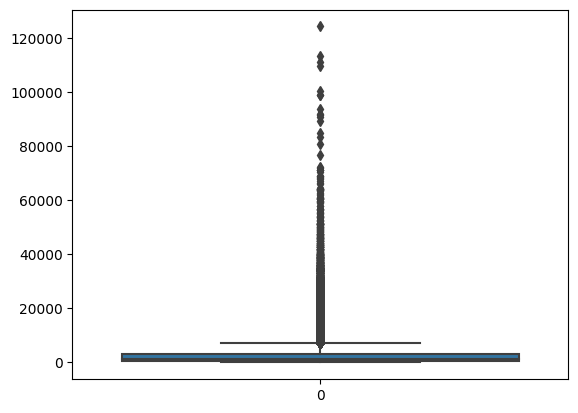

In [21]:
# Checking for outliers
sns.boxplot(data=train["Amount"])

<Axes: >

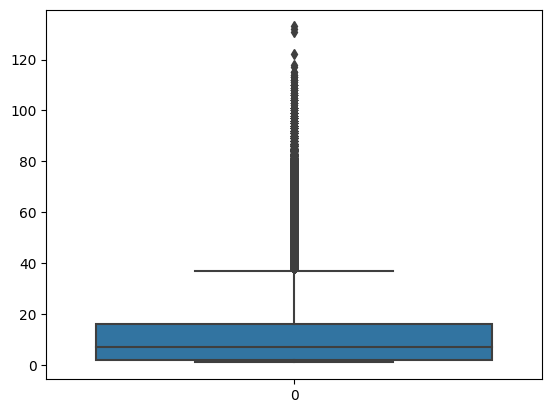

In [22]:
# Checking for outliers
sns.boxplot(data=train["refill_frequency"])

<Axes: >

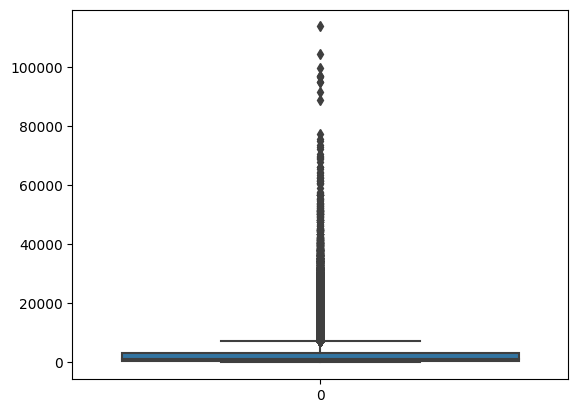

In [23]:
# Checking for outliers
sns.boxplot(data=train["revenue"])

<Axes: >

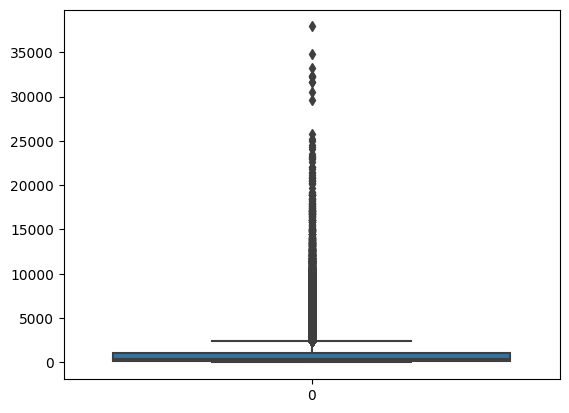

In [24]:
# Checking for outliers
sns.boxplot(data=train["arpu_segment"])

<Axes: >

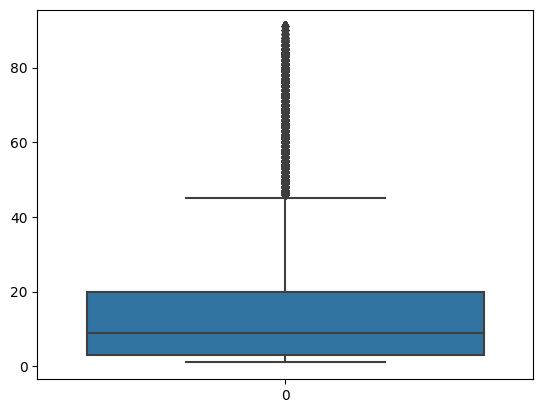

In [25]:
# Checking for outliers
sns.boxplot(data=train["frequency"])

<Axes: >

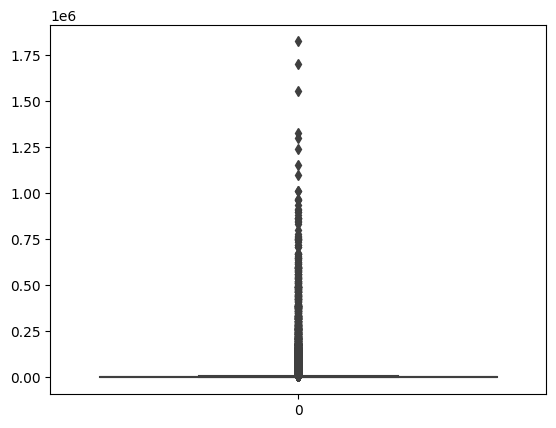

In [26]:
# Checking for outliers
sns.boxplot(data=train["data_volume"])

<Axes: >

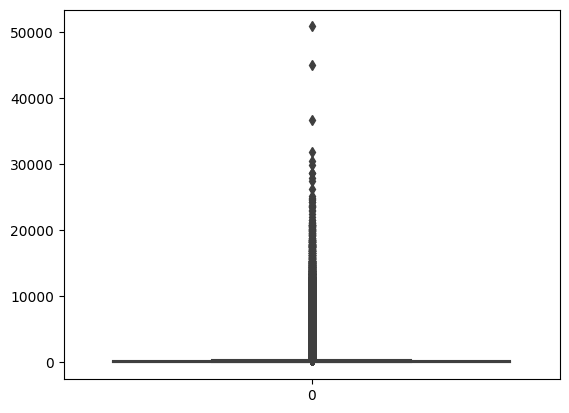

In [27]:
# Checking for outliers
sns.boxplot(data=train["on_net"])

<Axes: >

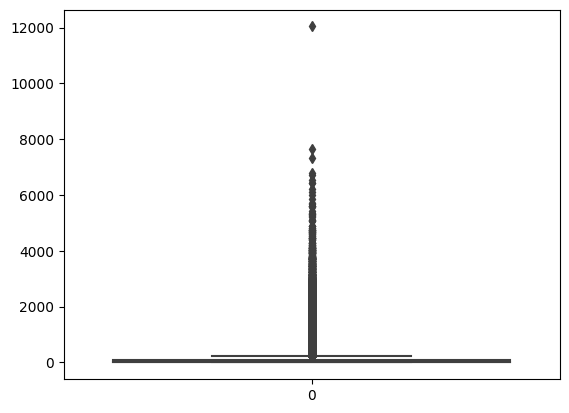

In [28]:
# Checking for outliers
sns.boxplot(data=train["Procuct_1"])

<Axes: >

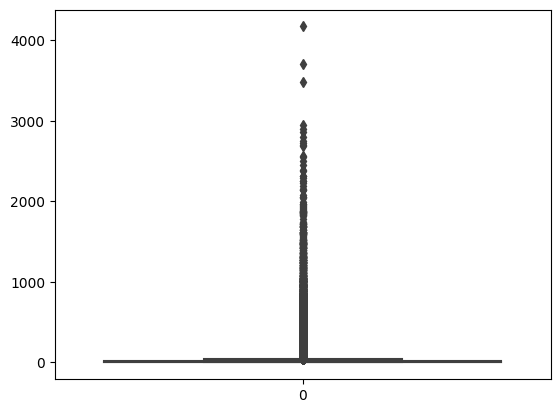

In [29]:
# Checking for outliers
sns.boxplot(data=train["Procuct_2"])

While there appear to be some outliers, it is unlikely that removing them will help the model's accuracy, as there is no clear cut place to decide where outliers begin and data ends.

### 2.4. Correlation

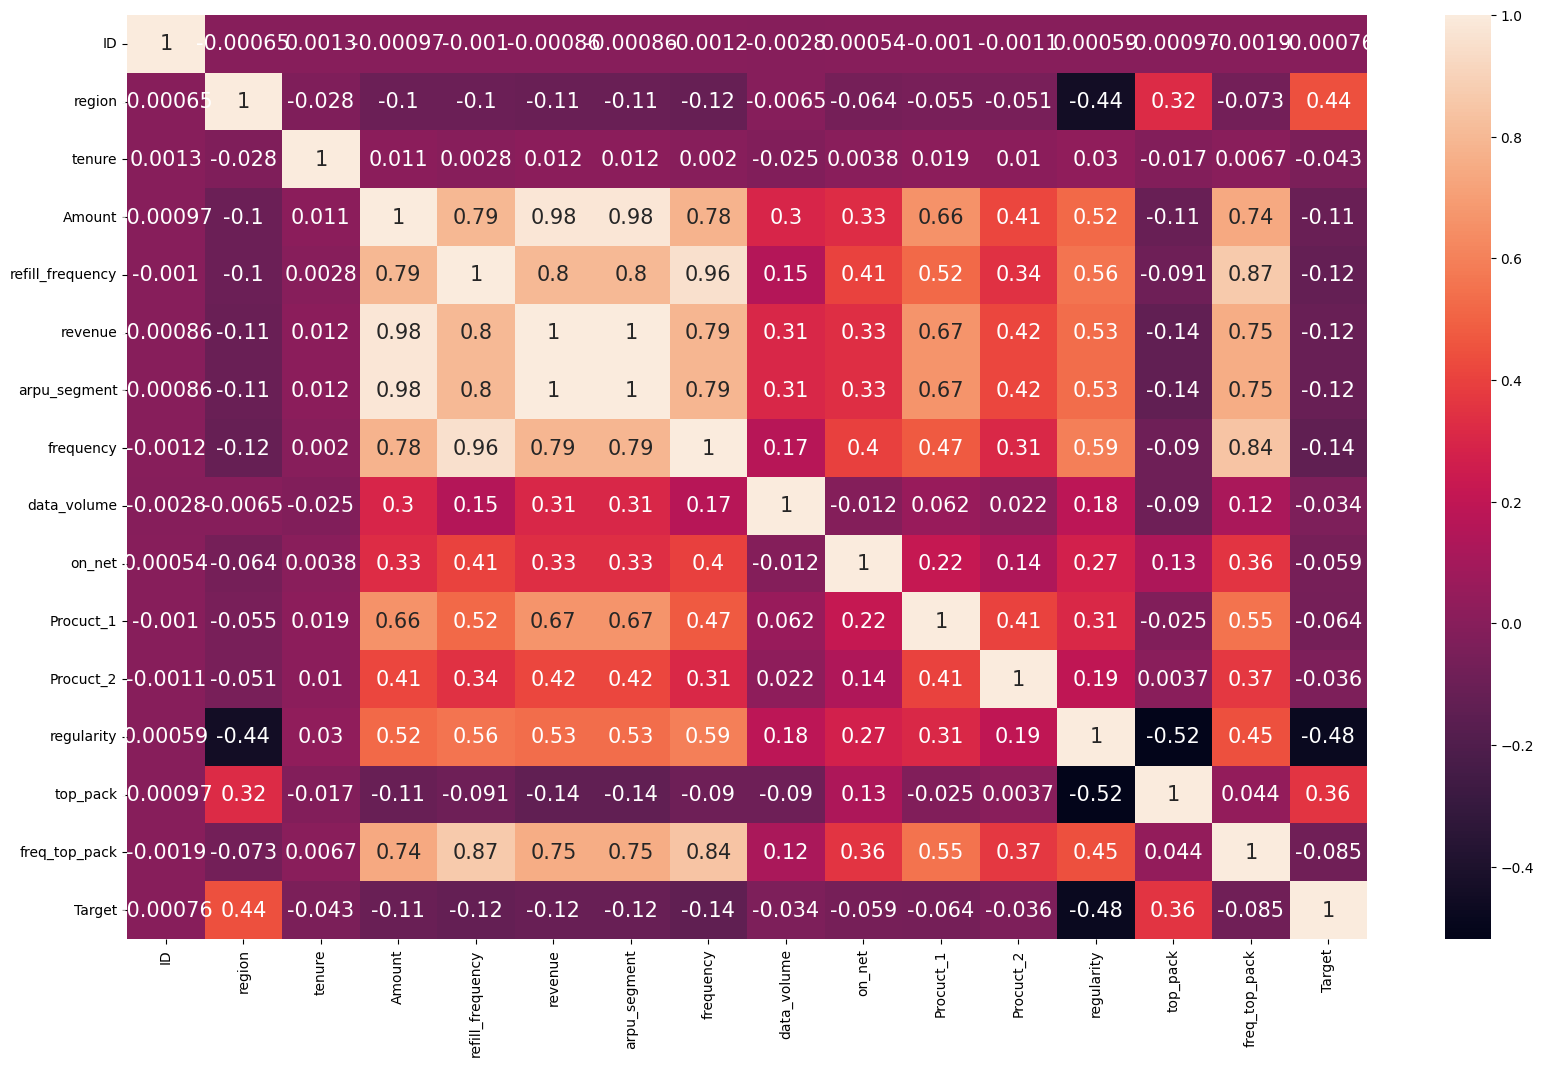

In [73]:
# Create new df for heatmap
corr_train = train_nonull.drop(['mrg'],axis=1)

# Convert target label to numerical Data
le = LabelEncoder()
corr_train['ID'] = le.fit_transform(corr_train['ID'])
corr_train['region'] = le.fit_transform(corr_train['region'])
corr_train['tenure'] = le.fit_transform(corr_train['tenure'])
#corr_train['mrg'] = le.fit_transform(corr_train['mrg']) doesn't show up due to only one number
corr_train['top_pack'] = le.fit_transform(corr_train['top_pack'])
plt.figure(figsize=(20,12))

# plotting correlation heatmap
dataplot = sns.heatmap(corr_train.corr(), annot=True,annot_kws={'size': 15})

# displaying heatmap
plt.show()

There are high levels of correlation between Amount, refill_frequency, revenue, arpu_segment, and frequency. This could cause issues with multicollinearity later. To prevent this we are going to drop columns with very high (above 0.9) correlation. Due to their lower correlation with the target variable, we will drop Amount, refill_frequency, and arpu_segment.

We are also going to drop columns with a very low correlation with the target variable (below 0.1). This includes the following columns: ID, tenure, data_volume, on_net, Procuct_1, Procuct_2, freq_top_pack, and mrg.

In [31]:
train_nomc = train_nonull.drop(['Amount', 'refill_frequency', 'arpu_segment', 'ID', 'tenure', 'data_volume', 'on_net','Procuct_1', 'Procuct_2', 'freq_top_pack', 'mrg'], axis= 1)
test_nomc = test_nonull.drop(['Amount', 'refill_frequency', 'arpu_segment', 'ID', 'tenure', 'data_volume', 'on_net','Procuct_1', 'Procuct_2', 'freq_top_pack', 'mrg'], axis= 1)

This leaves us with the following columns:

In [74]:
train_nomc.columns

Index(['region', 'revenue', 'frequency', 'regularity', 'top_pack', 'Target'], dtype='object')

This tells us that the information most predictive of whether a customer will leave or not is:


*   region
*   revenue
*   frequency
*   regularity
*   top_pack

In future, it may be worth only tracking these variables to save on database resources and staff costs.

### 3. Data Preparation

### 3.1. Preprocessing


We have created a simple preprocessing function to:

*   Handle conversion of data types
*   Convert categorical features to numerical features by using Label Encoder
*   Impute missing values

The processing function will be used for both train and test independent variables.

In [32]:
# Function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from integer to float
    float_array = data[["regularity"]].values.astype(float)

    # Label Encoder conversion
    data["region"] = le.fit_transform(data["region"])
    data["top_pack"] = le.fit_transform(data["top_pack"])

    # Impute missing values
    train_mice = data.copy()

    mice_imputer = IterativeImputer()

    train_mice['region'] = mice_imputer.fit_transform(train_mice[['region']])
    train_mice['revenue'] = mice_imputer.fit_transform(train_mice[['revenue']])
    train_mice['frequency'] = mice_imputer.fit_transform(train_mice[['frequency']])
    train_mice['top_pack'] = mice_imputer.fit_transform(train_mice[['top_pack']])

    return train_mice

In [33]:
# Preprocess the data
processed_train = preprocessing_data(train_nomc)
processed_test = preprocessing_data(test_nomc)

### 3.2. Downsampling


As mentioned earlier, the imbalance in classes of the target variable could create bias. To mitigate this, we will downsample the data, due to the sheer size of the dataset (as opposed to upsampling)

In [75]:
# Checking the size of the target classes
processed_train['Target'].groupby(processed_train['Target']).count()

Target
0    1225319
1     282515
Name: Target, dtype: int64

In [37]:
# Creating dataframes for each class
retain = processed_train[processed_train["Target"] == 1]
leave  = processed_train[processed_train["Target"] == 0]
print(retain.shape)
print(leave.shape)

(282515, 6)
(1225319, 6)


In [38]:
# Creating a downsampled dataframe
leave_downsample = resample(leave,
             replace=True,
             n_samples=len(retain),
             random_state=42)

In [39]:
# Concatenating the dataframes together
data_downsampled = pd.concat([leave_downsample, retain])

### 3.3. Split X and y

In [40]:

# Separate training features from target
X_train = data_downsampled.drop(['Target'], axis=1)
y_train = data_downsampled['Target'].values.astype(float)

print(y_train)

[0. 0. 0. ... 1. 1. 1.]


Sanity check

In [41]:
# The first train row
print(X_train[:1])

        region      revenue  frequency  regularity  top_pack
149813     0.0  2352.073152  13.967657           3     130.0


In [42]:
# Shape of the processed train set
print(X_train.shape)

(565030, 5)


### 3.4. Scaling

To balance the impact of all the variables, we scale them first.

In [43]:
# Scale our data into range of 0 and 1
def scaling(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scalednp = scaler.fit_transform(df)

    return scalednp

In [44]:
X_scaled = scaling(X_train)
test_scaled = scaling(processed_test)

### 4. Models and Experimentation

### 4.1. Train-Test Split

In [45]:
# Split training data into train and test

X_Train, X_Val, y_Train, y_val = train_test_split(X_scaled, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=42)

### 4.2. Base Model

Creating the actual model

XGB models are a combination of decision trees and gradient boosting. They re-iterate based on previous models to create a better model. This model was chosen for its speed and ability to prevent overfitting.

In [50]:
# Create XGB model
xg_model = XGBClassifier()

# Fitting the model
xg_model.fit(X_Train,y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 4.3. Testing

In [51]:
# Make predictions and evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get the error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of XGB classifier:  0.13477160504751962


In [52]:
# Check the f1 score
y_pred = xg_model.predict(X_Val)
f1_score(y_val, y_pred, average=None)

array([0.85740501, 0.87223797])

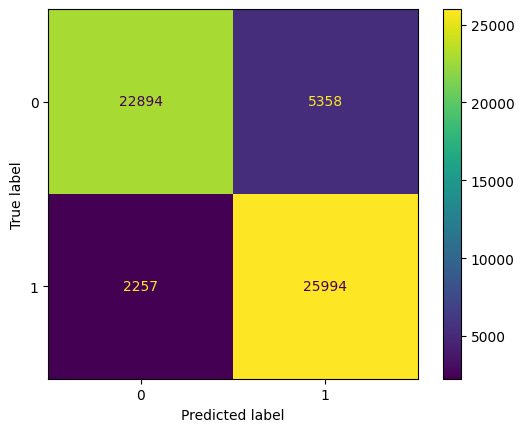

In [53]:
# Check the confusion matrix
cm = confusion_matrix(y_val, xg_y_model, labels=xg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xg_model.classes_)
disp.plot()
plt.show()

Here we see the model is doing well but struggles more with identifying when someone is going to leave.

### 4.4. Hyperparameter Tuning

This section helps us to fine-tune the model. Since it has already run, it has been commented out because it takes a while to run and only needs to be run once to get the hyperparameters.

In [56]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0
#     }

In [63]:
# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))

#     evaluation = [( X_Train, y_Train), ( X_Val, y_val)]

#     clf.fit(X_Train, y_Train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)


#     pred = clf.predict(X_Val)
#     accuracy = accuracy_score(y_val, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }

In [64]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

SCORE:
0.8625382723041255
SCORE:
0.862202006973081
SCORE:
0.8628922358104879
SCORE:
0.862750650407943
SCORE:
0.8626267631807161
SCORE:
0.8626975558819886
SCORE:
0.8624320832522167
SCORE:
0.8629276321611242
SCORE:
0.8626975558819886
SCORE:
0.8623612905509442
SCORE:
0.8625382723041255
SCORE:
0.8626798577066704
SCORE:
0.8626975558819886
SCORE:
0.8625913668300799
SCORE:
0.8623612905509442
SCORE:
0.8623612905509442
SCORE:
0.8625028759534892
SCORE:
0.8622904978496717
SCORE:
0.8627860467585792
SCORE:
0.8626444613560342
SCORE:
0.8628391412845335
SCORE:
0.8628214431092155
SCORE:
0.8626621595313523
SCORE:
0.8627329522326248
SCORE:
0.8626621595313523
SCORE:
0.8631223120896235
SCORE:
0.8627152540573066
SCORE:
0.8631931047908961
SCORE:
0.8631046139143055
SCORE:
0.8628037449338973
SCORE:
0.8627329522326248
SCORE:
0.8624497814275348
SCORE:
0.8626090650053979
SCORE:
0.8628214431092155
SCORE:
0.8631577084402599
SCORE:
0.862467479602853
SCORE:
0.8623081960249899
SCORE:
0.8627152540573066
SCORE:
0.862679

In [65]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7019617935298197, 'gamma': 8.172204197356677, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 52.0, 'reg_lambda': 0.17136400365399235}


Now we make a new model with the ideal hyperparameters.

In [66]:
# Fit by setting best parameters and evaluate model
xgb_model = XGBClassifier(colsample_bytree=0.702, min_child_weight=6, gamma=8.17, subsample=1, max_depth=3, reg_alpha=52, reg_lambda=0.17)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)
f1_score(y_val, y_pred, average=None)

array([0.85666897, 0.87040625])

### 5. Submission

In [67]:
test_scaled.shape

(380127, 5)

In [68]:
# Get the predicted result for the test Data
test.Target = xgb_model.predict(test_scaled)

In [69]:
# Create submission DataFrame
submission = pd.DataFrame({"ID": test["ID"],
                           "Target": test.Target})

In [70]:
#show the five sample
submission.sample(5)

,ID,Target
362089,ID_VUIM73WDPV2D,0
62418,ID_UVAA6VBG6NMF,0
311386,ID_HY4EJZ1C78OZ,1
208122,ID_HJC27DQN7R4K,0
274549,ID_4A65QLZI1VBL,1


In [71]:
# Create submission csv file csv file
submission.to_csv('tuned_with_features_selected.csv', index = False)
files.download('tuned_with_features_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6. Summary and Recommendations

In this notebook we have thoroughly examined the data, then cleaned and prepared it to create a model that can predict with approximately 86% accuracy if a customer will go inactive.